In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install 'transformers>=4.23.1,<=4.24.0'
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-zqw9kb9v
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-zqw9kb9v
  Resolved https://github.com/huggingface/transformers to commit 0ed3ffcb4461a244b87781a24e5ebd0a78f98142
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install wandb

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os
import pickle
import collections
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

from transformers import AutoModel, AutoTokenizer, AutoProcessor
#from transformers import AutoModelForZeroShotImageClassification

In [5]:
'''
dataset
'''
class VQADataset(Dataset):
    def __init__(self, mode='train', top_k=1000, max_length=14, isMedCLIP=False, isBioBERT=False):
        self.mode = mode
        self.max_length = max_length
        self.isMedCLIP = isMedCLIP
        self.isBioBERT = isBioBERT

        self.data_file = f'{mode}_data.txt'

        self.labelfreq = pickle.load(open('answers_freqs.pkl', 'rb'))
        self.label2idx = {x[0]: i+1 for i, x in enumerate(collections.Counter(self.labelfreq).most_common(n = top_k - 1))}
        self.label2idx["<unk>"] = 0

        if self.isMedCLIP:
            self.processor = MedCLIPProcessor()
        else:
            self.processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        if self.isBioBERT:
            self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        else:
            self.tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
        with open(os.path.join(self.data_file), 'r') as f:
            self.data = self.data = [line for line in f.read().strip().split('\n') if line.strip()]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_id, question, answer = self.data[idx].strip().split(',')
        if image_id[0]=='s':
            if image_id.split('.')[-1]=='jpg':
                image = Image.open(os.path.join('drive/MyDrive/images', image_id))
            else:
                image = Image.open(os.path.join('drive/MyDrive/images', image_id+'.jpg'))
        else:
            image = Image.open(os.path.join('drive/MyDrive/slake', image_id))

        question = self.tokenizer(question, max_length=self.max_length, truncation=True, padding='max_length', return_tensors="pt")
        question = {key: value.squeeze(0) for key, value in question.items()}

        answer = self.label2idx[answer if answer in self.label2idx else '<unk>']

        inputs = self.processor(images=image, return_tensors="pt")
        image = inputs['pixel_values'].squeeze(0)

        return image, question, answer

In [6]:
'''
model
'''
class ImageEncoder(nn.Module):
    def __init__(self, output_size=1024, dropout_prob=0.5, use_dropout=True, isMedCLIP=False):
        super(ImageEncoder, self).__init__()
        self.isMedCLIP = isMedCLIP
        if self.isMedCLIP:
            self.model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
            self.model.from_pretrained()
        else:
            self.model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-base-patch32")

        self.model.cuda()

        self.fc = nn.Sequential(
            nn.Linear(512, output_size),
        )
        if use_dropout:
            self.fc.append(nn.Dropout(dropout_prob))
        self.fc.append(nn.Tanh())

    def forward(self, images):
        images = images.to('cuda')
        if self.isMedCLIP:
            outputs = self.model.encode_image(pixel_values=images)
        else:
            outputs = self.model.get_image_features(pixel_values=images)
        image_embedding = self.fc(outputs)
        return image_embedding


class QuestionEncoder(nn.Module):
    def __init__(self, output_size=1024, dropout_prob=0.5, use_dropout=True, isBioBERT=False):
        super(QuestionEncoder, self).__init__()
        self.isBioBERT = isBioBERT
        if self.isBioBERT:
            self.bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", output_hidden_states=True)
        else:
            self.bert_model = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
        self.fc = nn.Sequential(
            nn.Linear(3072, output_size),
        )
        if use_dropout:
            self.fc.append(nn.Dropout(dropout_prob))
        self.fc.append(nn.Tanh())

    def forward(self, questions):
        x = self.bert_model(input_ids=questions['input_ids'], token_type_ids=questions['token_type_ids'], attention_mask=questions['attention_mask'])
        hidden_states = x[2]
        last_four_layers = hidden_states[-4:]
        cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
        x = torch.mean(cat_hidden_states, dim=1).squeeze()
        question_embedding = self.fc(x)
        return question_embedding


class VQABaseline(nn.Module):
    def __init__(self, embedding_size=1024, output_size=1000, dropout_prob=0.5,
                 attention_mechanism='element_wise_product', isMedCLIP=False, isBioBERT=False):
        super(VQABaseline, self).__init__()

        self.image_encoder = ImageEncoder(output_size=embedding_size, dropout_prob=dropout_prob, use_dropout=True, isMedCLIP=isMedCLIP)
        self.question_encoder = QuestionEncoder(output_size=embedding_size, dropout_prob=dropout_prob, use_dropout=True, isBioBERT=isBioBERT)
        self.attention_mechanism = attention_mechanism
        self.attention_fn = {
            'element_wise_product': lambda x, y: x * y,
            'sum': torch.add,
            'concat': lambda x, y: torch.cat((x, y), dim=1)
        }
        self.embedding_size_post_attention = {
            'element_wise_product': embedding_size,
            'sum': embedding_size,
            'concat': 2 * embedding_size
        }
        self.mlp = nn.Sequential(
            nn.Linear(self.embedding_size_post_attention[self.attention_mechanism], 1000),
            nn.Dropout(dropout_prob),
            nn.Tanh(),
            nn.Linear(1000, output_size),
        )

    def forward(self, images, questions):
        image_embeddings = self.image_encoder(images)
        question_embeddings = self.question_encoder(questions)
        final_embedding = self.attention_fn[self.attention_mechanism](image_embeddings, question_embeddings)
        output = self.mlp(final_embedding)
        return output

In [7]:
def collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)
    questions = {key: torch.stack([q[key] for q in questions]) for key in questions[0]}
    answers = torch.tensor(answers)
    return images, questions, answers

def calculate_accuracy(outputs, answers):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == answers).sum().item()
    return correct

def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0

    with tqdm(train_loader, desc='Training', unit='batch') as t:
        for batch_idx, (images, questions, answers) in enumerate(t):
            images = images.cuda()
            questions = {key: value.cuda() for key, value in questions.items()}
            answers = answers.cuda()

            outputs = model(images, questions)
            loss = criterion(outputs, answers)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            correct = calculate_accuracy(outputs, answers)
            epoch_correct += correct
            epoch_total += answers.size(0)

            t.set_postfix(loss=loss.item(), accuracy=correct / answers.size(0))

    epoch_loss /= epoch_total
    epoch_accuracy = epoch_correct / epoch_total

    return epoch_loss, epoch_accuracy

def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, questions, answers in val_loader:
            images = images.cuda()
            questions = {key: value.cuda() for key, value in questions.items()}
            answers = answers.cuda()

            outputs = model(images, questions)
            loss = criterion(outputs, answers)

            val_loss += loss.item() * images.size(0)
            correct = calculate_accuracy(outputs, answers)
            val_correct += correct
            val_total += answers.size(0)

    val_loss /= val_total
    val_accuracy = val_correct / val_total

    return val_loss, val_accuracy

def train(model_name, train_loader, val_loader, model, optimizer, num_epochs):
    wandb.init(project='BMED_MEDVQA')

    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        epoch_loss, epoch_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}, Total Accuracy: {epoch_accuracy:.4f}')
        wandb.log({'Train Loss': epoch_loss, 'Train Accuracy': epoch_accuracy})

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        wandb.log({'Validation Loss': val_loss, 'Validation Accuracy': val_accuracy})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'drive/MyDrive/best_' + model_name + '.pth')
            print('Model saved!')

In [8]:
def evaluate_random_sample(model, dataset, num_samples=1):
    random_indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in random_indices]

    sample_images, sample_questions, sample_answers = zip(*samples)
    sample_images = torch.stack(sample_images)
    sample_questions = {key: torch.stack([q[key] for q in sample_questions]) for key in sample_questions[0]}
    sample_answers = torch.tensor(sample_answers)

    model.eval()
    sample_images = sample_images.cuda()
    sample_questions = {key: value.cuda() for key, value in sample_questions.items()}
    sample_answers = sample_answers.cuda()

    with torch.no_grad():
        sample_outputs = model(sample_images, sample_questions)

    _, sample_predictions = torch.max(sample_outputs, 1)

    idx2label = {idx: label for label, idx in dataset.label2idx.items()}

    for i in range(num_samples):
        print(f'Image {i + 1}:')
        plt.imshow(sample_images[i].cpu().permute(1, 2, 0))
        plt.show()

        original_question = dataset.data[random_indices[i]].strip().split(',')[1]
        original_answer = dataset.data[random_indices[i]].strip().split(',')[2]

        print(f'Question: {original_question}')
        print(f'True Answer: {original_answer}')
        print(f'Predicted Answer: {idx2label[sample_predictions[i].item()]}')

In [ ]:
'''
CLIP, BERT
'''
train_dataset = VQADataset(mode='train')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataset = VQADataset(mode='val')
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
model = VQABaseline()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train('CLIP+BERT', train_loader, val_loader, model, optimizer, num_epochs=20)

Train Accuracy,▁
Train Loss,▁
Train Accuracy,0.29932
Train Loss,3.75622


Training: 100%|██████████| 347/347 [07:17<00:00,  1.26s/batch, accuracy=0.167, loss=4.61]


Epoch [1/20], Total Loss: 3.8174, Total Accuracy: 0.2901


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation Loss: 3.9251, Validation Accuracy: 0.4329
Model saved!


Training: 100%|██████████| 347/347 [07:20<00:00,  1.27s/batch, accuracy=0.667, loss=1.03]


Epoch [2/20], Total Loss: 2.7215, Total Accuracy: 0.3877
Validation Loss: 3.3583, Validation Accuracy: 0.4431
Model saved!


Training: 100%|██████████| 347/347 [07:22<00:00,  1.28s/batch, accuracy=0.5, loss=0.937]


Epoch [3/20], Total Loss: 2.5033, Total Accuracy: 0.3963
Validation Loss: 3.1223, Validation Accuracy: 0.4427
Model saved!


Training: 100%|██████████| 347/347 [07:23<00:00,  1.28s/batch, accuracy=0.5, loss=2.89]


Epoch [4/20], Total Loss: 2.3848, Total Accuracy: 0.4008
Validation Loss: 2.9578, Validation Accuracy: 0.4537
Model saved!


Training: 100%|██████████| 347/347 [07:19<00:00,  1.27s/batch, accuracy=0.333, loss=2.63]


Epoch [5/20], Total Loss: 2.3163, Total Accuracy: 0.4028
Validation Loss: 2.9270, Validation Accuracy: 0.4537
Model saved!


Training: 100%|██████████| 347/347 [07:19<00:00,  1.27s/batch, accuracy=0.5, loss=1.95]


Epoch [6/20], Total Loss: 2.2672, Total Accuracy: 0.4100
Validation Loss: 2.7415, Validation Accuracy: 0.4528
Model saved!


Training: 100%|██████████| 347/347 [07:22<00:00,  1.27s/batch, accuracy=0.5, loss=1.09]


Epoch [7/20], Total Loss: 2.2151, Total Accuracy: 0.4154
Validation Loss: 2.7878, Validation Accuracy: 0.4699


Training: 100%|██████████| 347/347 [07:18<00:00,  1.26s/batch, accuracy=0.167, loss=3.08]


Epoch [8/20], Total Loss: 2.1925, Total Accuracy: 0.4302
Validation Loss: 2.6739, Validation Accuracy: 0.4768
Model saved!


Training: 100%|██████████| 347/347 [07:16<00:00,  1.26s/batch, accuracy=0.5, loss=2.13]


Epoch [9/20], Total Loss: 2.1676, Total Accuracy: 0.4304
Validation Loss: 2.7125, Validation Accuracy: 0.4841


Training: 100%|██████████| 347/347 [07:14<00:00,  1.25s/batch, accuracy=0.5, loss=2.83]


Epoch [10/20], Total Loss: 2.1532, Total Accuracy: 0.4292
Validation Loss: 2.7962, Validation Accuracy: 0.4463


Training: 100%|██████████| 347/347 [07:17<00:00,  1.26s/batch, accuracy=0.5, loss=2.16]


Epoch [11/20], Total Loss: 2.1410, Total Accuracy: 0.4198
Validation Loss: 2.6816, Validation Accuracy: 0.4715


Training: 100%|██████████| 347/347 [07:17<00:00,  1.26s/batch, accuracy=0.5, loss=2.45]


Epoch [12/20], Total Loss: 2.1071, Total Accuracy: 0.4242
Validation Loss: 2.6719, Validation Accuracy: 0.4703
Model saved!


Training: 100%|██████████| 347/347 [07:22<00:00,  1.27s/batch, accuracy=0.333, loss=1.99]


Epoch [13/20], Total Loss: 2.0828, Total Accuracy: 0.4277
Validation Loss: 2.5414, Validation Accuracy: 0.4695
Model saved!


Training: 100%|██████████| 347/347 [07:17<00:00,  1.26s/batch, accuracy=0.667, loss=1.31]


Epoch [14/20], Total Loss: 2.0715, Total Accuracy: 0.4298
Validation Loss: 2.5950, Validation Accuracy: 0.4760


Training: 100%|██████████| 347/347 [07:13<00:00,  1.25s/batch, accuracy=0.333, loss=0.762]


Epoch [15/20], Total Loss: 2.0465, Total Accuracy: 0.4460
Validation Loss: 2.5711, Validation Accuracy: 0.4870


Training: 100%|██████████| 347/347 [07:17<00:00,  1.26s/batch, accuracy=0.167, loss=3.2]


Epoch [16/20], Total Loss: 2.0309, Total Accuracy: 0.4544
Validation Loss: 2.5540, Validation Accuracy: 0.4955


Training: 100%|██████████| 347/347 [07:16<00:00,  1.26s/batch, accuracy=0.167, loss=4.26]


Epoch [17/20], Total Loss: 2.0161, Total Accuracy: 0.4609
Validation Loss: 2.5661, Validation Accuracy: 0.4947


Training: 100%|██████████| 347/347 [07:16<00:00,  1.26s/batch, accuracy=0.167, loss=4.1]


Epoch [18/20], Total Loss: 2.0113, Total Accuracy: 0.4666
Validation Loss: 2.5417, Validation Accuracy: 0.4972


Training: 100%|██████████| 347/347 [07:16<00:00,  1.26s/batch, accuracy=0.833, loss=1.67]


Epoch [19/20], Total Loss: 1.9851, Total Accuracy: 0.4749
Validation Loss: 2.4832, Validation Accuracy: 0.5114
Model saved!


Training: 100%|██████████| 347/347 [07:16<00:00,  1.26s/batch, accuracy=0.5, loss=1.68]


Epoch [20/20], Total Loss: 1.9604, Total Accuracy: 0.4807
Validation Loss: 2.5586, Validation Accuracy: 0.5106


In [ ]:
torch.cuda.empty_cache()

In [10]:
'''
CLIP, BioBERT
'''
train_dataset = VQADataset(mode='train', isBioBERT=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataset = VQADataset(mode='val', isBioBERT=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
model = VQABaseline(isBioBERT=True)
model.load_state_dict(torch.load('drive/MyDrive/best_CLIP+BioBERT.pth'))
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train('CLIP+BioBERT', train_loader, val_loader, model, optimizer, num_epochs=9)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training:   0%|          | 0/347 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Training: 100%|██████████| 347/347 [32:58<00:00,  5.70s/batch, accuracy=0.333, loss=4]


Epoch [1/9], Total Loss: 2.1408, Total Accuracy: 0.4488
Validation Loss: 2.6812, Validation Accuracy: 0.4829
Model saved!


Training: 100%|██████████| 347/347 [07:22<00:00,  1.27s/batch, accuracy=0.5, loss=3.32]


Epoch [2/9], Total Loss: 2.0898, Total Accuracy: 0.4618
Validation Loss: 2.6816, Validation Accuracy: 0.4854


Training: 100%|██████████| 347/347 [07:20<00:00,  1.27s/batch, accuracy=0.667, loss=2.2]


Epoch [3/9], Total Loss: 2.0365, Total Accuracy: 0.4711
Validation Loss: 2.5005, Validation Accuracy: 0.5073
Model saved!


Training: 100%|██████████| 347/347 [07:22<00:00,  1.28s/batch, accuracy=0.5, loss=2.27]


Epoch [4/9], Total Loss: 1.9999, Total Accuracy: 0.4769
Validation Loss: 2.6091, Validation Accuracy: 0.4878


Training: 100%|██████████| 347/347 [07:20<00:00,  1.27s/batch, accuracy=0.167, loss=3.7]


Epoch [5/9], Total Loss: 1.9982, Total Accuracy: 0.4726
Validation Loss: 2.6151, Validation Accuracy: 0.5000


Training: 100%|██████████| 347/347 [07:20<00:00,  1.27s/batch, accuracy=0.667, loss=2.14]


Epoch [6/9], Total Loss: 2.0697, Total Accuracy: 0.4629
Validation Loss: 2.5500, Validation Accuracy: 0.5134


Training: 100%|██████████| 347/347 [07:20<00:00,  1.27s/batch, accuracy=0.833, loss=0.664]


Epoch [7/9], Total Loss: 1.9617, Total Accuracy: 0.4806
Validation Loss: 2.6432, Validation Accuracy: 0.5069


Training: 100%|██████████| 347/347 [07:21<00:00,  1.27s/batch, accuracy=0.333, loss=2.95]


Epoch [8/9], Total Loss: 1.9264, Total Accuracy: 0.4876
Validation Loss: 2.5737, Validation Accuracy: 0.5081


Training: 100%|██████████| 347/347 [07:21<00:00,  1.27s/batch, accuracy=0.167, loss=2.6]


Epoch [9/9], Total Loss: 1.9142, Total Accuracy: 0.4873
Validation Loss: 2.4693, Validation Accuracy: 0.5102
Model saved!


In [11]:
torch.cuda.empty_cache()

In [14]:
!pip install git+https://github.com/RyanWangZf/MedCLIP.git
!pip install 'transformers>=4.23.1,<=4.24.0'

  Cloning https://github.com/RyanWangZf/MedCLIP.git to /tmp/pip-req-build-4cjka2jd
  Running command git clone --filter=blob:none --quiet https://github.com/RyanWangZf/MedCLIP.git /tmp/pip-req-build-4cjka2jd
  Resolved https://github.com/RyanWangZf/MedCLIP.git to commit 9c3396f20d5d54e4fae241b8cb06ca45848e98c9
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manyl

In [10]:
from medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPProcessor

In [1]:
!pip list | grep transformers

transformers                     4.24.0


In [11]:
'''
MedCLIP, BERT
'''
train_dataset = VQADataset(mode='train', isMedCLIP=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dataset = VQADataset(mode='val', isMedCLIP=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
model = VQABaseline(isMedCLIP=True)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train('MedCLIP+BERT', train_loader, val_loader, model, optimizer, num_epochs=20)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT 


 Download pretrained model from: https://storage.googleapis.com/pytrial/medclip-vit-pretrained.zip
load model weight from: ./pretrained/medclip-vit


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: ksp7292 (yws0322). Use `wandb login --relogin` to force relogin


Training: 100%|██████████| 174/174 [06:36<00:00,  2.28s/batch, accuracy=0.167, loss=3.93]


Epoch [1/20], Total Loss: 4.6423, Total Accuracy: 0.2190
Validation Loss: 3.6597, Validation Accuracy: 0.3728
Model saved!


Training: 100%|██████████| 174/174 [06:43<00:00,  2.32s/batch, accuracy=0.333, loss=2.55]


Epoch [2/20], Total Loss: 3.0114, Total Accuracy: 0.3637
Validation Loss: 3.1586, Validation Accuracy: 0.4183
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.32s/batch, accuracy=0.667, loss=1.77]


Epoch [3/20], Total Loss: 2.6065, Total Accuracy: 0.3985
Validation Loss: 2.9397, Validation Accuracy: 0.4508
Model saved!


Training: 100%|██████████| 174/174 [06:43<00:00,  2.32s/batch, accuracy=0.333, loss=2.15]


Epoch [4/20], Total Loss: 2.4359, Total Accuracy: 0.4046
Validation Loss: 2.8387, Validation Accuracy: 0.4642
Model saved!


Training: 100%|██████████| 174/174 [06:43<00:00,  2.32s/batch, accuracy=0.333, loss=2.77]


Epoch [5/20], Total Loss: 2.3367, Total Accuracy: 0.4121
Validation Loss: 2.6705, Validation Accuracy: 0.4659
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.32s/batch, accuracy=0.167, loss=2.66]


Epoch [6/20], Total Loss: 2.2697, Total Accuracy: 0.4315
Validation Loss: 2.6180, Validation Accuracy: 0.4886
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.32s/batch, accuracy=0.167, loss=3.31]


Epoch [7/20], Total Loss: 2.2085, Total Accuracy: 0.4494
Validation Loss: 2.5037, Validation Accuracy: 0.4959
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.33s/batch, accuracy=0.333, loss=3.17]


Epoch [8/20], Total Loss: 2.1573, Total Accuracy: 0.4589
Validation Loss: 2.4963, Validation Accuracy: 0.4963
Model saved!


Training: 100%|██████████| 174/174 [06:43<00:00,  2.32s/batch, accuracy=0.667, loss=2.29]


Epoch [9/20], Total Loss: 2.1129, Total Accuracy: 0.4672
Validation Loss: 2.4923, Validation Accuracy: 0.5069
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.32s/batch, accuracy=0.333, loss=3.27]


Epoch [10/20], Total Loss: 2.0662, Total Accuracy: 0.4743
Validation Loss: 2.4906, Validation Accuracy: 0.4988
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.32s/batch, accuracy=0.5, loss=2.43]


Epoch [11/20], Total Loss: 2.0442, Total Accuracy: 0.4729
Validation Loss: 2.3617, Validation Accuracy: 0.5154
Model saved!


Training: 100%|██████████| 174/174 [06:43<00:00,  2.32s/batch, accuracy=0.667, loss=1.79]


Epoch [12/20], Total Loss: 2.0164, Total Accuracy: 0.4788
Validation Loss: 2.3858, Validation Accuracy: 0.5183


Training: 100%|██████████| 174/174 [06:42<00:00,  2.31s/batch, accuracy=0.667, loss=1.05]


Epoch [13/20], Total Loss: 1.9484, Total Accuracy: 0.4926
Validation Loss: 2.4128, Validation Accuracy: 0.5171


Training: 100%|██████████| 174/174 [06:42<00:00,  2.31s/batch, accuracy=0.5, loss=2.01]


Epoch [14/20], Total Loss: 1.8987, Total Accuracy: 0.5105
Validation Loss: 2.2181, Validation Accuracy: 0.5476
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.33s/batch, accuracy=0.333, loss=1.64]


Epoch [15/20], Total Loss: 1.8459, Total Accuracy: 0.5257
Validation Loss: 2.1900, Validation Accuracy: 0.5638
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.32s/batch, accuracy=0.667, loss=2.88]


Epoch [16/20], Total Loss: 1.7938, Total Accuracy: 0.5454
Validation Loss: 2.1875, Validation Accuracy: 0.5671
Model saved!


Training: 100%|██████████| 174/174 [06:44<00:00,  2.33s/batch, accuracy=0.667, loss=0.778]


Epoch [17/20], Total Loss: 1.7471, Total Accuracy: 0.5571
Validation Loss: 2.1337, Validation Accuracy: 0.5748
Model saved!


Training: 100%|██████████| 174/174 [06:43<00:00,  2.32s/batch, accuracy=0.833, loss=0.681]


Epoch [18/20], Total Loss: 1.7100, Total Accuracy: 0.5651
Validation Loss: 2.1370, Validation Accuracy: 0.5890


Training: 100%|██████████| 174/174 [06:42<00:00,  2.31s/batch, accuracy=0.667, loss=1.52]


Epoch [19/20], Total Loss: 1.6707, Total Accuracy: 0.5764
Validation Loss: 2.1179, Validation Accuracy: 0.5984
Model saved!


Training: 100%|██████████| 174/174 [06:45<00:00,  2.33s/batch, accuracy=0.833, loss=0.774]


Epoch [20/20], Total Loss: 1.6350, Total Accuracy: 0.5817
Validation Loss: 2.0563, Validation Accuracy: 0.6061
Model saved!


In [16]:
torch.cuda.empty_cache()

In [ ]:
'''
MedCLIP, BioBERT
'''
train_dataset = VQADataset(mode='train', isMedCLIP=True, isBioBERT=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dataset = VQADataset(mode='val', isMedCLIP=True, isBioBERT=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
model = VQABaseline(isMedCLIP=True, isBioBERT=True)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train('MedCLIP+BioBERT', train_loader, val_loader, model, optimizer, num_epochs=20)

Image 1:


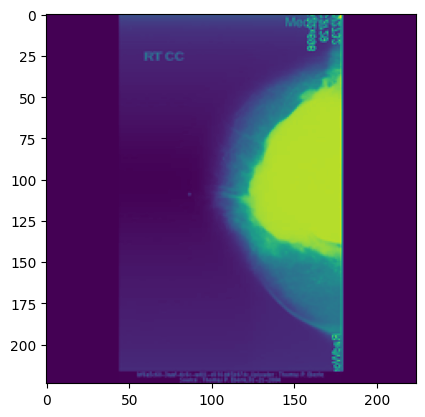

Question: what organ system is imaged?
True Answer: breast
Predicted Answer: musculoskeletal
Image 2:


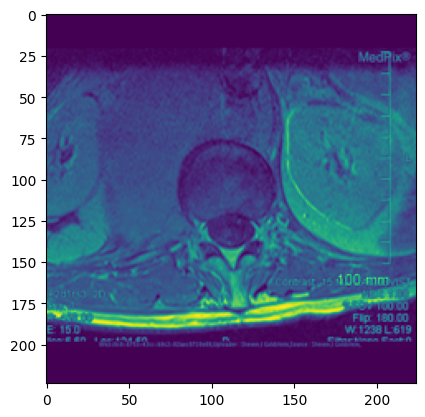

Question: what is most alarming about this mri?
True Answer: hodgkin's lymphoma
Predicted Answer: <unk>
Image 3:


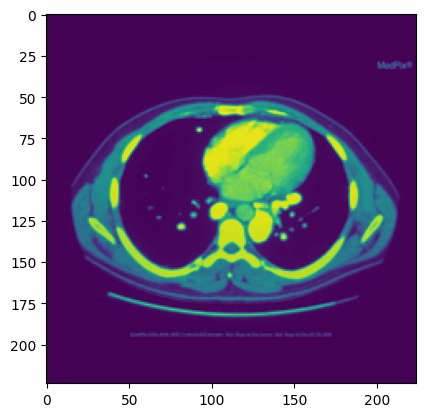

Question: which plane is this ct scan taken in?
True Answer: axial
Predicted Answer: axial
Image 4:


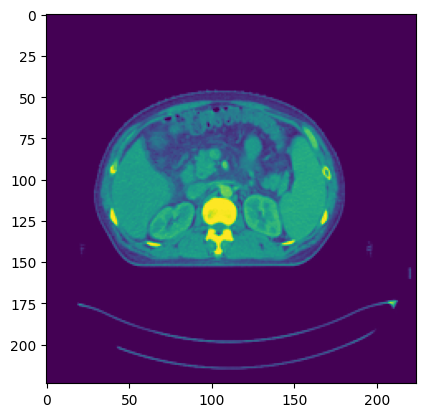

Question: does the humerus head exist in this picture
True Answer: no
Predicted Answer: no
Image 5:


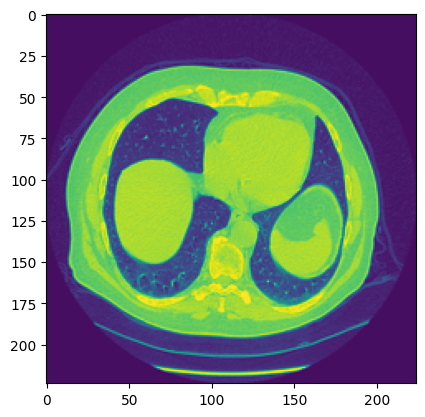

Question: does the picture contain liver
True Answer: yes
Predicted Answer: no


In [12]:
evaluate_random_sample(model, val_dataset, num_samples=5)